In [1]:
import torch.nn as nn
import torch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from data.dataloader import data_generator, data_generator_2types, data_generator_real_data
from models.losses import loss_function, loss_function_portfolio
from utils.utils import reconstruct_cov

In [4]:
from models.gru_denoiser import BiGRUSpectralDenoiser

In [5]:
from training.trainer import Trainer

In [6]:
from data.real_dataloader import real_data_pipeline

In [ ]:
from estimator.QIS import QIS
from estimator.shaffer import torch_cov_pairwise


## NN

### Training loop — Generated Data

In [8]:
model_generated_data = BiGRUSpectralDenoiser(hidden_size=512) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

In [10]:
trainer = Trainer(
    model=model_generated_data, is_train_on_real_data = False, loss_function=loss_function, data_generator=data_generator, lr = 5e-4, weight_decay=1e-6,
    batch_size=100, epochs=50, N_min=200, N_max=200, T_min=150, T_max=150, log_interval=10, accumulate_steps=1, dataset=None, missing_constant = 2,
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses = trainer.train()

Starting training for 50 epochs…
Epoch 10/50 — loss: 0.022425
Epoch 20/50 — loss: 0.022343
Epoch 30/50 — loss: 0.018828
Epoch 40/50 — loss: 0.019885
Epoch 50/50 — loss: 0.022605
Training complete.


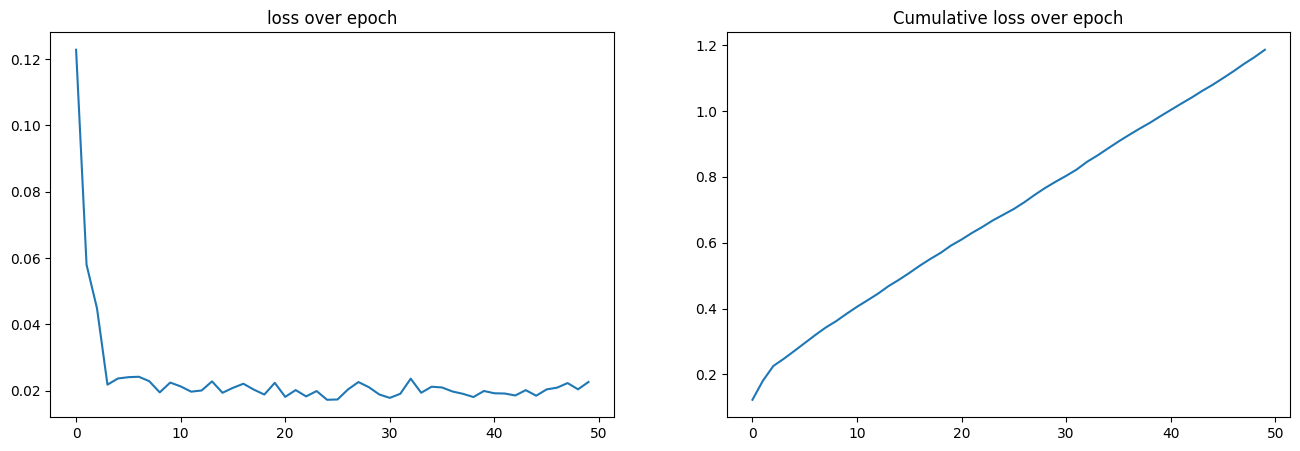

In [11]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("loss over epoch")
plt.subplot(1,2,2)
plt.plot(np.cumsum(losses))
plt.title("Cumulative loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

In [12]:
# save the model
torch.save(model_generated_data.state_dict(), "models/spectral_denoiser_model_generated.pth")

we have to stop after the slow down of deacrese. otherwise we might face overfitting

In [13]:
state_dict_generated_data = torch.load("models/spectral_denoiser_model_generated.pth")
model_generated_data.load_state_dict(state_dict_generated_data)
model_generated_data.eval()

BiGRUSpectralDenoiser(
  (gru): GRU(6, 512, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (activation): Softplus(beta=1.0, threshold=20.0)
)

### Surface (oos)

In [14]:
batch_size_oos_1 = 25
N_list_test_1 = [20, 40, 60, 80, 100, 120, 140, 160, 180,200,220]
T_list_test_1 = [20, 40,60, 80, 100, 120, 150, 180, 200, 220, 240, 260, 280, 300]

In [49]:
mse = nn.MSELoss()

In [50]:
losses_value = []
mse_value = []

In [51]:
for n in N_list_test_1:
    for t in T_list_test_1:
        input_seq, Q_emp_oos_i, Sigma_true_oos_i, T_t = next(data_generator(batch_size=batch_size_oos_1, missing_constant=2, N_min=n, N_max=n, T_min=t, T_max=t))
        lam_pred_test_i = model_generated_data(input_seq)
        losses_value.append(loss_function(lam_pred_test_i, Q_emp_oos_i, Sigma_true_oos_i, t).item())
        mse_value.append(mse(Sigma_true_oos_i, reconstruct_cov(Q_emp_oos_i, lam_pred_test_i)).item())


In [52]:
# meshing
loss_grid = np.array(losses_value).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
mse_grid = np.array(mse_value).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test_1), np.array(T_list_test_1), indexing='ij')

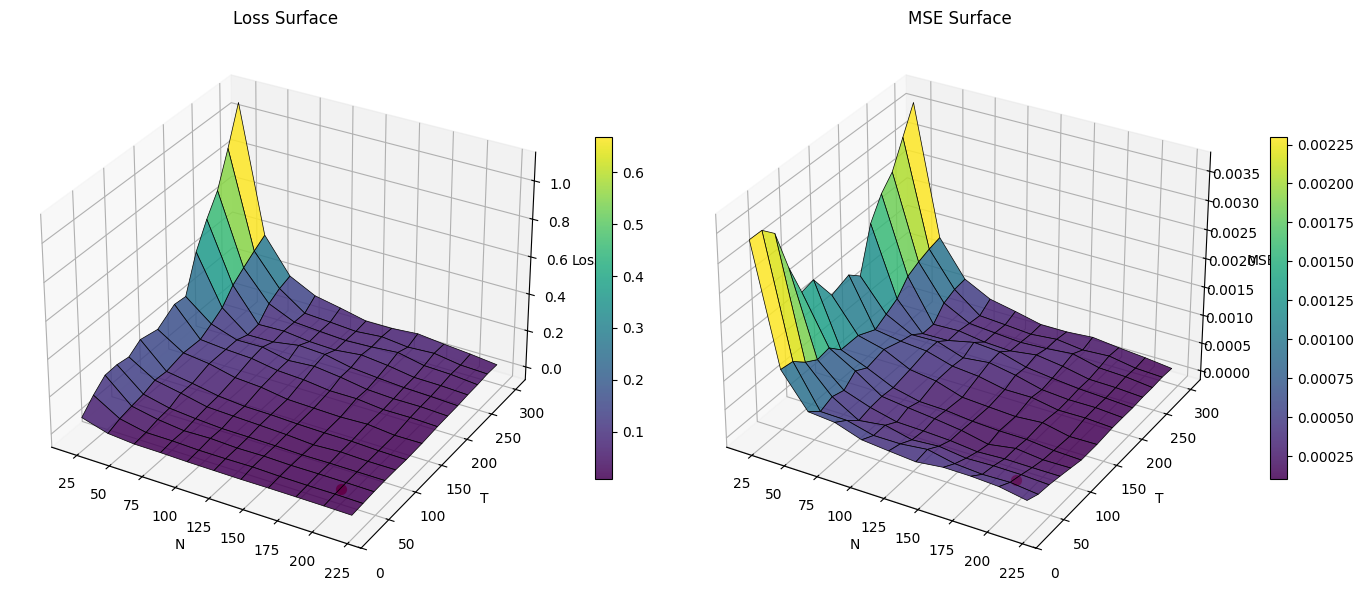

In [ ]:
fig = plt.figure(figsize=(14, 6))

ax_loss = fig.add_subplot(1, 2, 1, projection="3d")
ax_mse  = fig.add_subplot(1, 2, 2, projection="3d")

# --- Loss surface ---
surf_loss = ax_loss.plot_surface(
    N_mesh, T_mesh, loss_grid,
    cmap="viridis",
    edgecolor="k",
    linewidth=0.5,
    alpha=0.85,
)

ax_loss.set(
    xlabel="N",
    ylabel="T",
    zlabel="Loss",
    title="Loss Surface",
)

ax_loss.scatter(200, 50, loss_grid[10, 1], c="red", s=50)

# --- MSE surface ---
surf_mse = ax_mse.plot_surface(
    N_mesh, T_mesh, mse_grid,
    cmap="viridis",
    edgecolor="k",
    linewidth=0.5,
    alpha=0.85,
)

ax_mse.set(
    xlabel="N",
    ylabel="T",
    zlabel="MSE",
    title="MSE Surface",
)

ax_mse.scatter(200, 50, mse_grid[10, 1], c="red", s=50)

# Colorbars (one per surface, clean & honest)
fig.colorbar(surf_loss, ax=ax_loss, shrink=0.6)
fig.colorbar(surf_mse,  ax=ax_mse,  shrink=0.6)

plt.tight_layout()
plt.savefig("images/loss_surface_double.png")
plt.show()

### Comparaison (oos)

In [60]:
batch_size_oos = 500

In [61]:
input_seq_cov_miss, Q_emp_miss, Sigma_true_miss, T    = next(data_generator(batch_size_oos, missing_constant = 2, N_min=200, N_max=200, T_min=150, T_max=150))
input_seq_cov_no_miss, Q_emp_no_miss, Sigma_true_no_miss, T = next(data_generator(batch_size_oos, missing_constant = 1, N_min=200, N_max=200, T_min=150, T_max=150))

In [62]:
lam_QIS,Q_QIS  = QIS(Sigma_true_miss, batch_size_oos, 200, T)

In [63]:
lam_pred_miss    = model_generated_data(input_seq_cov_miss)
lam_emp_miss     = input_seq_cov_miss[:,:,0]
lam_pred_no_miss = model_generated_data(input_seq_cov_no_miss)
lam_emp_no_miss  = input_seq_cov_no_miss[:,:,0]

Comparaison matrix $\Sigma$

In [64]:
Sigma_pred_miss    = reconstruct_cov(Q_emp_miss, lam_pred_miss)
Sigma_pred_no_miss = reconstruct_cov(Q_emp_no_miss, lam_pred_no_miss)
Sigma_emp_miss     = reconstruct_cov(Q_emp_miss, lam_emp_miss)
Sigma_emp_no_miss  = reconstruct_cov(Q_emp_no_miss, lam_emp_no_miss)
Sigma_QIS          = reconstruct_cov(Q_QIS, lam_QIS)

fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true_miss)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true_no_miss)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true_miss)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true_no_miss)
fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true_no_miss)

print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss:.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss:.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss:.6f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss:.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS:.6f}")

MSE Sigma after miss + NN:         0.000136
MSE Sigma after no miss + NN :     0.000132
MSE Sigma after miss + no NN :     0.010467
MSE Sigma after no miss  + no NN : 0.006737
MSE Sigma QIS :                    0.000235


Graphique : 

/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_21479/1037830364.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


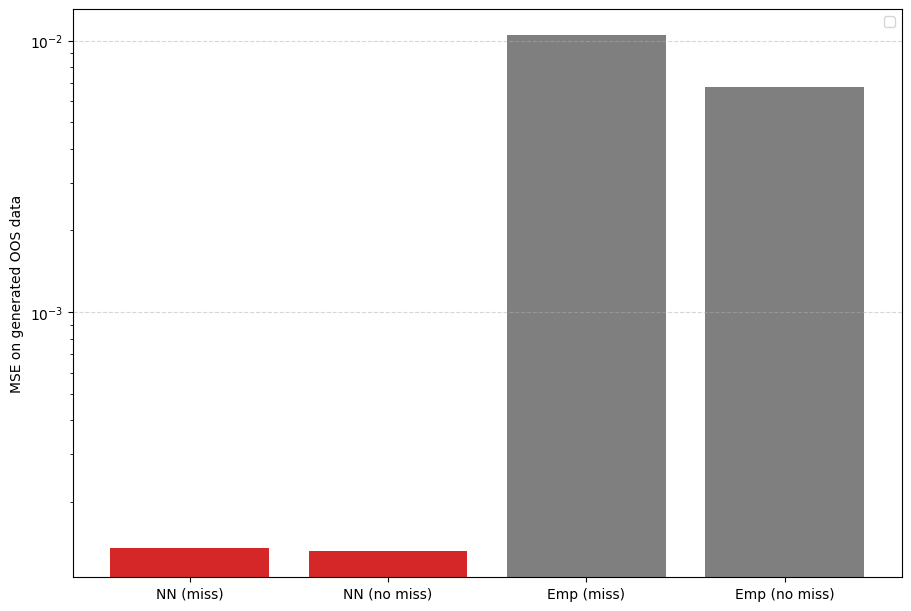

In [65]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [fro_Sigma_pred_miss.item(), fro_Sigma_pred_no_miss.item(), fro_Sigma_emp_miss.item(), fro_Sigma_emp_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()


We except this on generated data, YES very good !

- remove comparaison with trace : if necessary it can be normalized at the output of our network $\lambda_j * N / \sum_{i=1}^{N}\lambda_i $
- remove comparaison with eigenvalues : not meaning full as they are in another base !

### BackTesting / Trying on real data

Covariances depend on scale

Correlations are scale-invariant $\rho_{ij} = \frac{\Sigma_{ij}}{\sigma_i \sigma_j + \epsilon_i}$

=> should we then learn on correlation instead of covariance

Some stocks do not move at all over 10 days  
- variance = 0  
- correlation = NaN  


Should the distance to Sigma_true be replaced by the distance to $\Sigma_{nomiss \quad QIS}$ ?

2 means for the comparaison : 
- compute estimated revenu on oos sample following in sample
- compute distance with a matrix

In [66]:
batch_size = 300
n_stocks = 200
T = 50

dataset = real_data_pipeline(
    batch_size,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = 10,
    n_days_in = T,
    shift = 1, # cus that day in rn
    n_stocks = n_stocks,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [67]:
input_seq_miss, Q_emp_miss, R_oos, T    = next(data_generator_real_data(missing_constant = 2, N_min=200, N_max=200, T_min=150, T_max=150, dataset=dataset))
input_seq_no_miss, Q_emp_no_miss, R_oos, T = next(data_generator_real_data(missing_constant = 1, N_min=200, N_max=200, T_min=150, T_max=150, dataset=dataset))

In [ ]:
Sigma_true = torch_cov_pairwise(R_oos)

#### Compute estimated revenu on oos sample following in sample

Say you have $R = (r_0, ..., r_T)$ and $R_{oos} = (r_0, ..., r_T, ... ,r_{T+10})$  
From R with missing values you compute $\Sigma_hat$, and then compute $w = \frac{\hat{\Sigma}^{-1} \mathbb{1}}{\mathbb{1}^T\hat\Sigma\mathbb{1}}$   
We set when NaNs are ...
Then compute $P_{oos} = w^T(r_{T+1} ... r_{T+10})$ Then sum and you get the expected return for the next d (=10 here) days  

To better compare we have many way of compute $\Sigma$
- with no data missingness
    - $\Sigma_{QIS}$
    - $\Sigma_{NN}$
    - $\Sigma_{cov}$
    - Nearest covariance matrix ?
- with data missingness
    - $\Sigma_{NN}$
    - $\Sigma_{cov}$

Shouldn't we train on real data instead of simulated data and we should work on minimizing that latter loss (we aim at maximizing the profit) ?  

What loss to use ? I try to maximize the profit for now switch to $n w^T \Sigma_{oos} w$

Question on $\Sigma_{oos}$

In [70]:
lam_pred_miss       = model_generated_data(input_seq_miss)
lam_emp_cov_miss    = input_seq_miss[:,:,0]
lam_pred_no_miss    = model_generated_data(input_seq_no_miss)
lam_emp_cov_no_miss = input_seq_no_miss[:,:,0]

In [71]:
Sigma_pred_miss    = reconstruct_cov(Q_emp_miss, lam_pred_miss)
Sigma_pred_no_miss = reconstruct_cov(Q_emp_no_miss, lam_pred_no_miss)
Sigma_emp_miss     = reconstruct_cov(Q_emp_miss, lam_emp_cov_miss)
Sigma_emp_no_miss  = reconstruct_cov(Q_emp_no_miss, lam_emp_cov_no_miss)
# Sigma_QIS          = reconstruct_cov(Q_QIS, lam_QIS)

fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true)
# fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true_no_miss)

print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss:.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss:.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss:.7f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss:.7f}")
# print(f"MSE Sigma QIS :                    {fro_Sigma_QIS:.6f}")

MSE Sigma after miss + NN:         0.005064
MSE Sigma after no miss + NN :     0.005115
MSE Sigma after miss + no NN :     0.0000011
MSE Sigma after no miss  + no NN : 0.0000007


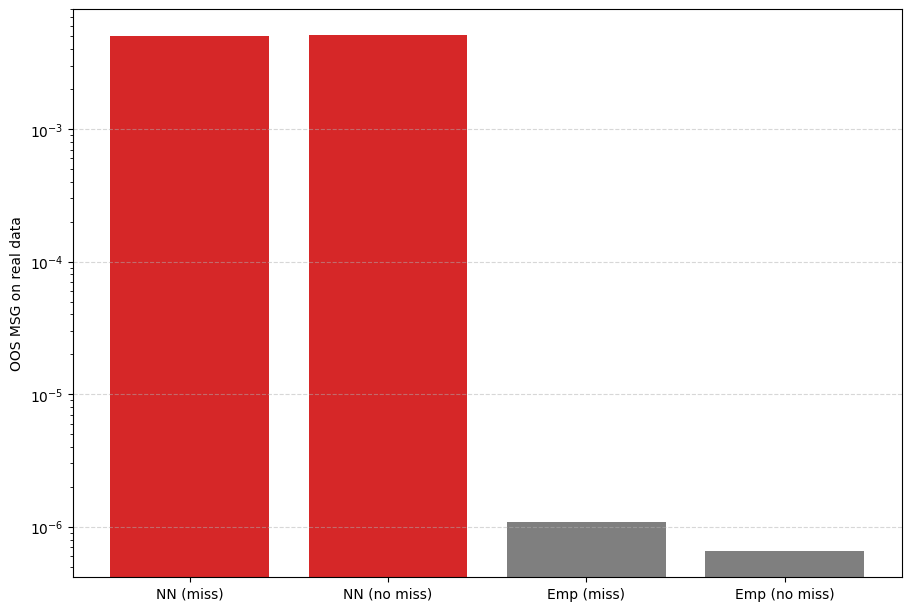

In [72]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [fro_Sigma_pred_miss.item(), fro_Sigma_pred_no_miss.item(), fro_Sigma_emp_miss.item(), fro_Sigma_emp_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('OOS MSG on real data')
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()


Can't compute QIS, bc matrix isn't positive define => normal  
Very bad result, let's train on real data

### Add hyperparameter selection

To be added
- we could add : eigenvalues monotonically decreasing
- hyperparameter tuning
- k split cross validation

To be written in the report
- Write abt RIE and that we do smt simular
- Write abt GRU and how it helps us here
- A problem is that eigenVector are noisy
- write about QIS — QIS near to perfect — dig in report theory

Tried
- stochastic gradient descent
